In [1]:
import popsims
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
from popsims.abs_mags import get_abs_mag
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] =20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.titlesize'] = 20

splat.initializeStandards(all=True)

%matplotlib inline

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database


In [2]:
#get evolutionary models
m='baraffe2003' #la base
thin_disk=popsims.make_systems(model_name=m, recompute=True, range=[0.01, 0.1, 0., 8.0],\
                              nsample=5e5)
#thick_disk=popsims.make_systems(model_name=m, recompute=True, range=[0.01, 0.1, 8, 14.0],\
#    nsample=5e5, filename='/users/caganze/research/popsims/data/{}_thick.pkl'.format(m))
#halo=popsims.make_systems(model_name='roman2020', range=[0.01, 0.2, 10, 13.5 ],
#                             recompute=True, nsample=5e5)

True

In [343]:
def get_mag_from_luminosity(lumn, bc, log=True):
    if log:
        return -2.5*np.log10(lumn)+4.74-bc
    else:
        return -2.5*lumn+4.74-bc
    
def fillipazzo_bolometric_correction(spt, filt='2MASS_J', mask=None):
    """
    number spectral type
    """
    #for float
    if isinstance(spt, (np.floating, float, int)):
        return spe.typeToBC(spt, filt, ref='filippazzo2015')
    #vectorized solution, masking things outside the range
    else:
        ref='filippazzo2015'
        spt=np.array(spt)
        res=np.ones_like(spt)*np.nan
        
        if mask is None: mask=np.zeros_like(spt).astype(bool)
    
        bc = np.polyval(splat.SPT_BC_RELATIONS[ref]['filters'][filt]['coeff'], spt-splat.SPT_BC_RELATIONS[ref]['sptoffset'])
        bc_error = splat.SPT_BC_RELATIONS[ref]['filters'][filt]['fitunc']
        
        rands=np.random.normal(bc, bc_error)
        
        np.place(res, ~mask, rands )

        return res

def make_systems(bfraction=0.2, recompute=False, model='baraffe2003', 
                mass_age_range=[0.01, 0.1, 0., 8.0], nsample=5e5, return_singles=False):
    
    model_res=popsims.simulate_spts(name=model,
                                   recompute=recompute, range=mass_age_range,\
                              nsample=nsample)
    
    #singles
    singles=model_res['sing_evol']
    singles['abs_2MASS_J']= get_abs_mag(mods['sing_spt'], '2MASS J')[0]
    singles['abs_2MASS_H']= np.ones_like(singles['abs_2MASS_J'])*np.nan
    singles['is_binary']= np.zeros_like(mods['sing_spt']).astype(bool)
    singles['spt']=mods['sing_spt']
    singles['prim_spt']=mods['sing_spt']
    singles['sec_spt']=np.ones_like(mods['sing_spt'])*np.nan
    
    #binary
    binaries={}
    binaries['age']=mods['prim_evol']['age']
    binaries['mass']=mods['prim_evol']['mass']+mods['sec_evol']['mass']
    binaries['luminosity']=np.log10(10**(mods['prim_evol']['luminosity']).value+\
    10**(mods['sec_evol']['luminosity']).value)
    binaries['temperature']=mods['prim_evol']['temperature']
    binaries['spt']=mods['binary_spt']
    binaries['prim_spt']=mods['prim_spt']
    binaries['sec_spt']=mods['sec_spt']
    binaries['is_binary']=np.ones_like(mods['sec_spt']).astype(bool)
    
    #bolometric corrections
    bcs=fillipazzo_bolometric_correction(binaries['spt'], filt='2MASS_J', 
                                        mask=binaries['spt']>39.)
    
    binaries['abs_2MASS_J']=get_mag_from_luminosity( binaries['luminosity'],\
                                                    bcs, log=False)
    binaries['abs_2MASS_H']=np.ones_like(mods['prim_spt'])*np.nan

    
    #compute numbers to choose based on binary fraction
    ndraw= int(len(mods['sing_spt'])/(1-binary_fraction))-int(len(mods['sing_spt']))
    
    #random list of binaries to choose
    random_int=np.random.choice(np.arange(len(binaries['spt'])), ndraw)
    
    chosen_binaries={}
    for k in binaries.keys():
        chosen_binaries[k]=binaries[k][random_int]
        
   
    #combine the to dictionaries 
    return pd.concat([pd.DataFrame(singles), pd.DataFrame(chosen_binaries)])


In [329]:
dt=popsims.simulate_spts()

In [345]:
vals=make_systems()

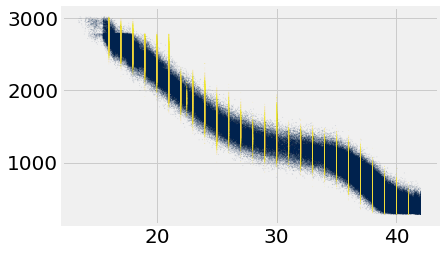

In [360]:
fig, ax=plt.subplots()
ax.scatter( vals.spt, vals.temperature, marker='.', s=1, alpha=0.1,
           c=vals.is_binary, cmap='cividis')

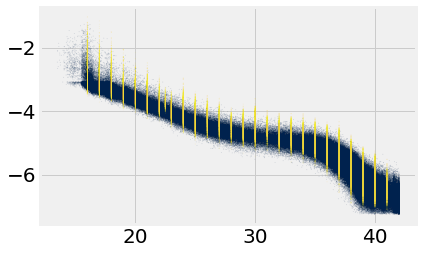

In [359]:
fig, ax=plt.subplots()
ax.scatter( vals.spt, vals.luminosity, marker='.', s=1, alpha=0.1,
           c=vals.is_binary, cmap='cividis')

In [356]:
vals.luminosity

0        -5.710245
1        -5.356897
2        -5.959784
3        -6.088308
4        -6.092254
            ...   
499995   -5.522079
499996   -3.326335
499997   -5.127159
499998   -6.206474
499999   -6.028149
Name: luminosity, Length: 1000000, dtype: float64

In [4]:
total_lum=10**((mods['sec_evol']['luminosity']).value) +10**((mods['prim_evol']['luminosity']).value) 

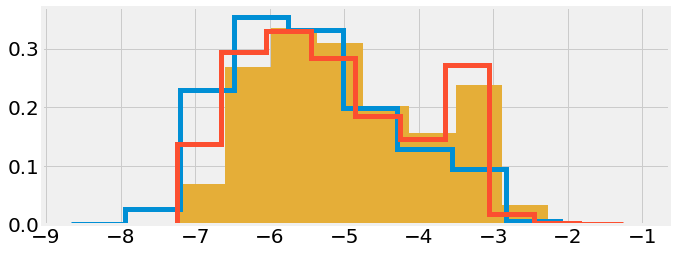

In [5]:
fig, ax=plt.subplots(figsize=(10, 4))
h=plt.hist((mods['sec_evol']['luminosity']).value, histtype='step', lw=5, density=True)
h=plt.hist((mods['prim_evol']['luminosity']).value, histtype='step', lw=5, density=True)
h=plt.hist(np.log10(total_lum), density=True)

In [168]:
binary_fraction=0.5
#nbin= int(len(model_vals['sing_spt'])*binary_fraction) #number of binaries
ndraw= int(len(mods['sing_spt'])/(1-binary_fraction))-int(len(mods['sing_spt']))


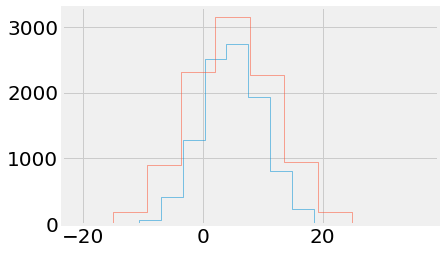

In [216]:
h=plt.hist(np.random.normal(5, 5, 10000), histtype='step')
h=plt.hist(np.random.normal(np.random.normal(5, 5, 10000), 5), histtype='step')

[Text(0.5, 0, 'Primary'), Text(0, 0.5, 'System')]

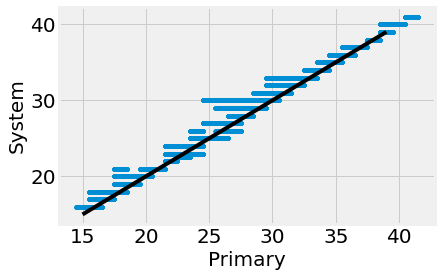

In [170]:
fig, ax=plt.subplots()
plt.plot(mods['prim_spt'], mods['binary_spt'], '.')
plt.plot(np.arange(15, 40), np.arange(15, 40), c='k')
ax.set(xlabel='Primary', ylabel='System')

In [7]:
random_dr=np.random.choice(np.arange(len(mods['binary_spt'])), ndraw)
#nans=np.isnan(mods['binary_spt'])

total_lum=10**((mods['sec_evol']['luminosity']).value) +10**((mods['prim_evol']['luminosity']).value) 

binaries={'spt':(mods['binary_spt'])[random_dr],
            'teff': (mods['prim_evol']['temperature'])[random_dr],
            'age': (mods['prim_evol']['age'])[random_dr],
            'mass': (mods['prim_evol']['mass'])[random_dr]\
                    +(mods['prim_evol']['mass'])[random_dr], 
         'luminosity': total_lum[random_dr] }

In [8]:
from popsims.abs_mags import get_abs_mag

In [11]:
get_abs_mag(binaries['spt'], '2MASS J')

(array([15.28731128, 16.50231128, 23.89231128, ..., 21.89231128,
        20.56231128, 14.93731128]),
 0.4)

In [13]:
#spsim.UVWpopulation(u,e_uvw=[0.,0.,0.],nsamp=1000,verbose=False)
import splat.empirical as spe

In [37]:
bcs=np.array([spe.typeToBC(x, '2MASS J', ref='filippazzo2015' ) for x in binaries['spt']])

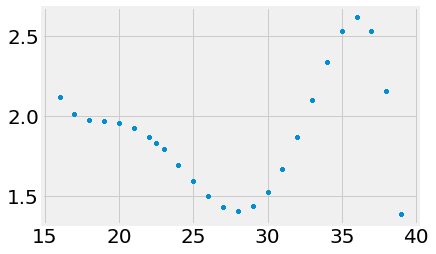

In [49]:
plt.plot(binaries['spt'], np.vstack(bcs)[:,0] , '.')

In [39]:
#spe.typeToBC?

In [147]:
binaries['BC']=np.vstack(bcs)[:,0]
binaries['Abs J']= -2.5*np.log10(binaries['luminosity'])-np.vstack(bcs)[:,0]+4.74

In [138]:
#Lbol= 

In [136]:
spe.typeToLbol(20, invert=False)

(-3.5694000000000043, 0.133)

In [65]:
from tqdm import tqdm

In [63]:
sing_bcs=np.array([spe.typeToBC(x, '2MASS J', ref='filippazzo2015' ) for x in mods['sing_spt']])

In [113]:
sing_mags=get_abs_mag(mods['sing_spt'], '2MASS J')
bin_mags= get_abs_mag(binaries['spt'], '2MASS J')

In [148]:
sing_mags_from_lumn=-2.5*(mods['sing_evol']['luminosity'].value)-np.vstack(sing_bcs)[:,0]+4.74

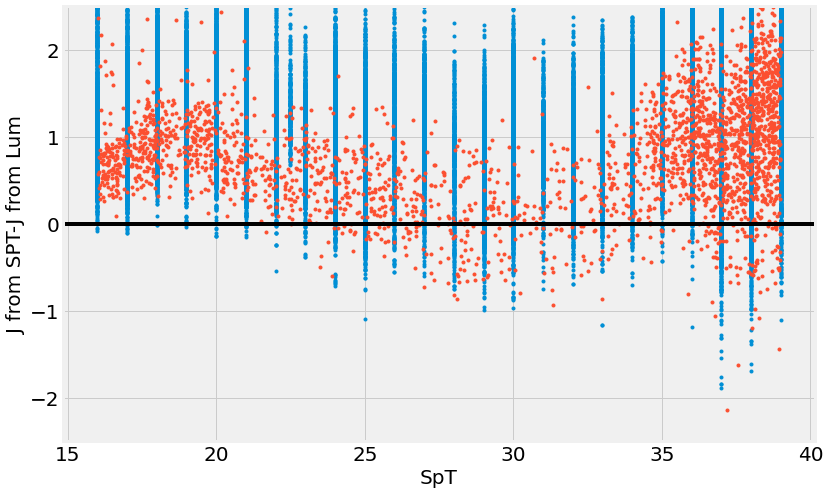

In [171]:
fig,ax=plt.subplots(figsize=(12, 8))
plt.plot(binaries['spt'], bin_mags[0]-binaries['Abs J'], '.' )
plt.plot(mods['sing_spt'], sing_mags[0]-sing_mags_from_lumn, '.' )
ax.set( ylim=[-2.5, 2.5], xlabel='SpT', ylabel='J from SPT-J from Lum')
ax.axhline(0.0, c='k')

[(5.0, 30.0)]

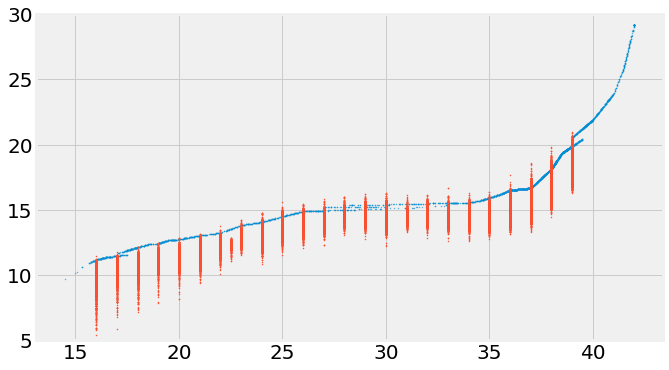

In [172]:
fig, ax=plt.subplots(figsize=(10, 6))
ax.scatter(mods['sing_spt'], sing_mags[0], alpha=0.5, s=1)
ax.scatter(binaries['spt'],binaries['Abs J'], s=1)
ax.set(ylim=[5, 30])

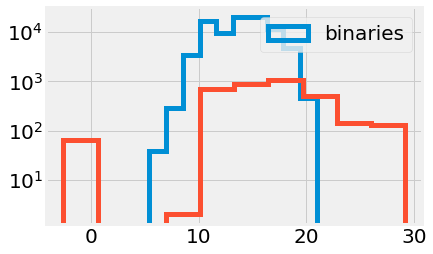

In [155]:
plt.hist(binaries['Abs J'], log=True, histtype='step', lw=5, label='binaries')
plt.hist( sing_mags[0], log=True, histtype='step', lw=5)
plt.legend()

In [60]:
len( sing_mags[0])

500000

In [132]:
-2.5*np.log10(2)

-0.752574989159953